In [2]:
from __future__ import division, unicode_literals, print_function  
import numpy as np
import matplotlib.pyplot as plt
import pims  # image reading routines
import os  #operating system
#import matplotlib as mpl
#from scipy import signal

import pandas as pd
#from pandas import DataFrame, Series  

import trackpy as tp
#http://soft-matter.github.io/trackpy/v0.5.0/
from scipy import ndimage  # for shifting images

from pims import pipeline  # for video frames
from pims import Frame
#from scipy.optimize import minimize  # for fitting
#import cv2 as cv2  # for Hough transform circle finding
#from scipy.interpolate import griddata  # for resampling
#import matplotlib.patches as mpatches   # circles
#from scipy.ndimage import median_filter  
from scipy.signal import savgol_filter  # for smoothing

# from pyquaternion import Quaternion  #for rotations
#http://kieranwynn.github.io/pyquaternion/

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from track_lib import  *  # some subroutines writting specifically for marble tracking

###  dice tracking

not sure how we are doing it yet

In [4]:
# read in frames
frames_dir = '/WORK/Research/Summer-2021_SpinTracking/painted_frames/dice*.png'
framesrgb = pims.open(frames_dir)  # this is d8_6-16_04.mp4 video
# that was processed with 
#ffmpeg -i d8_6-16_04.mp4   -ss 00:00:0.000 -vframes 600 dice%04d.png -hide_banner

fps =3000.0  #video fps?
d8_length = 23.65 #  mm with calipers measured red to red pts and green to green opposite points
theta_cam_deg = 45 # camera angl?e
print('number of frames  ',len(framesrgb))  # number of frames
oroot = 'dice_d8_'  #output file root

number of frames   319


Frame([[ 54,  51,  49, ..., 105, 101, 101],
       [ 53,  51,  48, ...,  99,  99,  98],
       [ 54,  54,  53, ..., 111, 108, 105],
       ...,
       [ 64,  66,  73, ..., 108, 106, 107],
       [ 57,  59,  67, ..., 118, 118, 119],
       [ 57,  58,  60, ..., 115, 116, 117]], dtype=uint8)
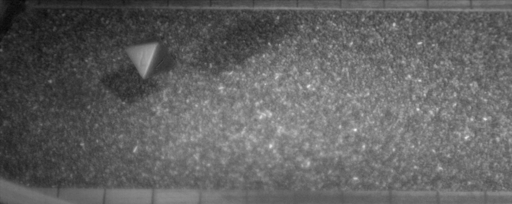

In [5]:
#plt.imshow(framesrgb[80][:,:,2],cmap='gray') # this is the blue image
framesrgb[80][:,:,2]

Frame([[[ 37,  25,  37],
        [ 33,  21,  33],
        [ 30,  21,  36],
        ...,
        [ 54,  44, 100],
        [ 54,  45,  96],
        [ 51,  42,  93]],

       [[ 37,  25,  37],
        [ 36,  24,  36],
        [ 36,  27,  42],
        ...,
        [ 53,  43,  99],
        [ 52,  43,  94],
        [ 48,  39,  90]],

       [[ 39,  25,  38],
        [ 37,  23,  36],
        [ 34,  25,  36],
        ...,
        [ 42,  38, 101],
        [ 41,  37, 102],
        [ 40,  36, 101]],

       ...,

       [[ 75,  47,  64],
        [ 74,  46,  63],
        [ 72,  49,  76],
        ...,
        [ 11,  35, 109],
        [  6,  39, 110],
        [  5,  38, 109]],

       [[ 62,  35,  59],
        [ 67,  40,  64],
        [ 68,  47,  75],
        ...,
        [ 23,  39, 116],
        [ 11,  39, 112],
        [  9,  37, 110]],

       [[ 59,  32,  56],
        [ 61,  34,  58],
        [ 59,  38,  66],
        ...,
        [ 24,  40, 117],
        [ 15,  43, 116],
        [ 12,  40, 113]]], dtype=uint8)
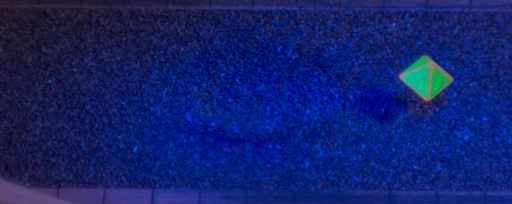

In [6]:
framesrgb[200]

In [7]:
framesrgb[10].shape

(512, 1280, 3)

Frame([[25, 25, 26, ..., 94, 94, 93],
       [28, 26, 27, ..., 88, 88, 84],
       [29, 28, 30, ..., 83, 86, 83],
       ...,
       [47, 54, 54, ..., 90, 82, 77],
       [54, 54, 50, ..., 93, 82, 82],
       [52, 48, 45, ..., 97, 85, 79]], dtype=uint8)
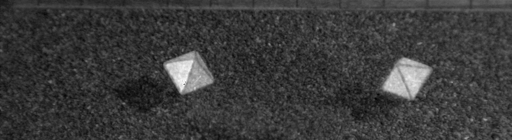

In [8]:
framesrgb[90][0:350,0:1280,1]  + framesrgb[190][0:350,0:1280,1]  #  first locate region of image we want!

In [17]:
#Looks like we want the whole image
i0=0
i1=440  # cutting the bottom
j0=0
j1=1280

Frame([[38., 40., 38., ..., 49., 44., 44.],
       [42., 42., 42., ..., 43., 39., 39.],
       [39., 40., 42., ..., 40., 37., 37.],
       ...,
       [43., 43., 40., ...,  7.,  7.,  6.],
       [37., 38., 39., ..., 11.,  9.,  7.],
       [47., 45., 39., ..., 15.,  9.,  3.]])
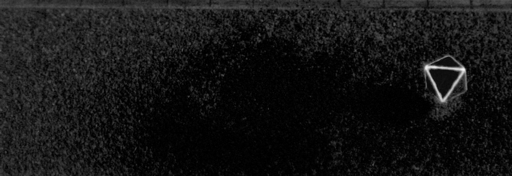

In [35]:
j=210
a=1.0; b =0.0; c = -0.0 # rgb
a*framesrgb[j][i0:i1,j0:j1,0] + b*framesrgb[j][i0:i1,j0:j1,1] + c*framesrgb[j][i0:i1,j0:j1,2]
# red vertex is bright!

Frame([[16.2, 18. , 16.2, ..., 41.1, 40.6, 40.6],
       [19.8, 19.8, 19.8, ..., 35.7, 36.1, 36.1],
       [18.1, 19. , 20.8, ..., 34. , 35.3, 35.3],
       ...,
       [25.7, 25.7, 32. , ..., 22.3, 29.3, 28.4],
       [21.3, 22.2, 29.1, ..., 27.9, 29.1, 27.3],
       [30.3, 28.5, 29.1, ..., 31.5, 29.1, 23.7]])
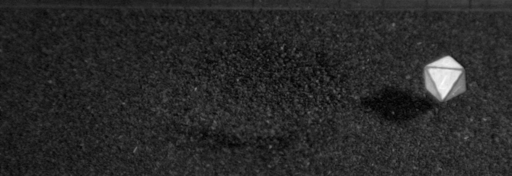

In [19]:
j=210
a=-0.1; b =1.0; c = -0.0 # rgb
a*framesrgb[j][i0:i1,j0:j1,0] + b*framesrgb[j][i0:i1,j0:j1,1] + c*framesrgb[j][i0:i1,j0:j1,2]
# green vertices are now bright!

Frame([[ 31.,  33.,  31., ..., 100.,  95.,  95.],
       [ 35.,  35.,  35., ...,  94.,  90.,  90.],
       [ 42.,  43.,  45., ..., 105., 105., 105.],
       ...,
       [ 67.,  67.,  60., ...,  93.,  95.,  94.],
       [ 55.,  56.,  58., ...,  94.,  94.,  92.],
       [ 65.,  63.,  58., ...,  98.,  94.,  88.]])
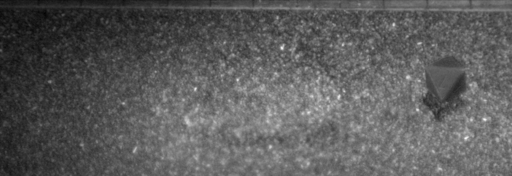

In [20]:
j=210
a=-0.0; b =0.0; c = 1.0 # rgb
a*framesrgb[j][i0:i1,j0:j1,0] + b*framesrgb[j][i0:i1,j0:j1,1] + c*framesrgb[j][i0:i1,j0:j1,2]
# blue is bright!

In [21]:
# make a color adjust, here to bring out red vertex
color_rgb_video_r = color_rgb(framesrgb,i0,i1,j0,j1,1.0,-0.0,-0.0) # 
# make a color adjust, here to bring out green vertex
color_rgb_video_g = color_rgb(framesrgb,i0,i1,j0,j1,-0.1,1.0,-0.0) # 
color_rgb_video_b = color_rgb(framesrgb,i0,i1,j0,j1,0.0,0.0,1.0) # blue
#imid = int(len(color_rgb_video_1)/2)
#plt.figure(figsize=(10,4))
#plt.imshow(color_rgb_video_1[j],cmap='gray')
# these are now grey scale images

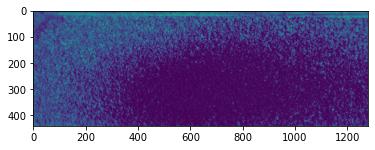

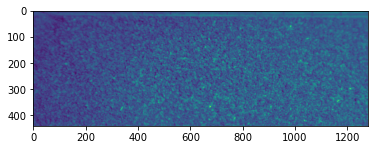

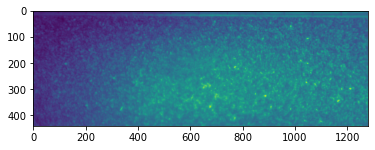

In [22]:
# make a median images
medianim_r = makemedian(0,5,color_rgb_video_r[0:80]) 
medianim_g = makemedian(0,5,color_rgb_video_g[0:80]) 
medianim_b = makemedian(0,5,color_rgb_video_b[0:200]) 

In [23]:
# substract median image from the whole video # returns gray image (but floats)
processed_video_r = sub_median(color_rgb_video_r,medianim_r)
processed_video_g = sub_median(color_rgb_video_g,medianim_g)
processed_video_b = sub_median(color_rgb_video_b,medianim_b)

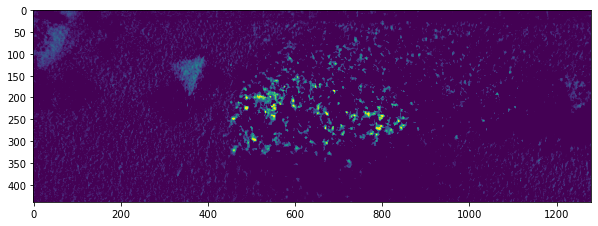

In [24]:
# make a sequence of images from the blue only
di=20
seq_b = sumseq(processed_video_b,di) 

plt.figure(figsize=(10,4))
plt.imshow(seq_b,vmin=0,vmax=15)


pixelscale is 0.0855 mm/pixel


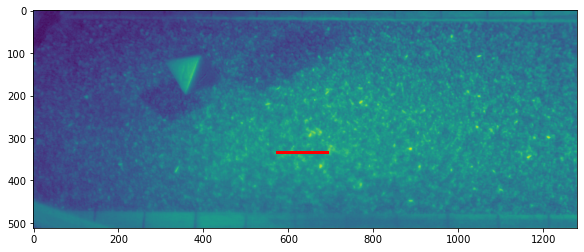

In [26]:
# find the pixel scale by adjusting the red bar which should be 1cm long
plt.figure(figsize=(10,4))
plt.imshow(framesrgb[80][:,:,2])
dL=117; x0=574; x1=x0+dL; y0=333;
plt.plot([x0,x1],[y0,y0],'r-',lw=3)
pixscale = 10.0/dL  # in mm/pixel
print ('pixelscale is {:.4f} mm/pixel'.format(pixscale))

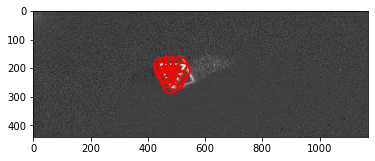

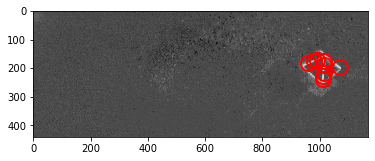

<AxesSubplot:>

In [30]:
# for tracking red dot
# adjust and check spot radius and minmass on  single images 
# for finding spots on the marble 
video = processed_video_r

rrad = 9 # radius , adjust this! we will use these values later on
minmass = 800.  # how bright are peaks, adjust this!
xx0=60; xx1=1230 # for display of image
imid = 100
f = tp.locate(video[imid][:,xx0:xx1], rrad, invert=False, \
              minmass=minmass)
tp.annotate(f, video[imid][:,xx0:xx1])

xx0=60; xx1=1230 # for display of image
imid = 200
f = tp.locate(video[imid][:,xx0:xx1], rrad, invert=False, \
              minmass=minmass)
tp.annotate(f, video[imid][:,xx0:xx1])


In [52]:
# track the red dot
maxdist = 22  # max distance between frames for linking
memory=13 #how many frames trajectory can go missing in linking
stublength = 20  # remove short tracks
f0=5 # first frame
t1a,particle_id_array=track_link_stub(video,rrad,minmass,f0,maxdist,memory,stublength)

Frame 325: 3 trajectories present.
Before: 69
After: 4
[ 0  1 14 46]


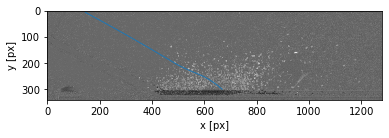

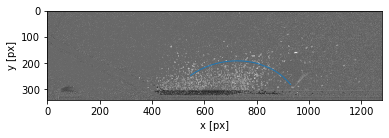

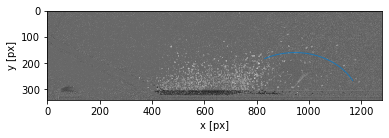

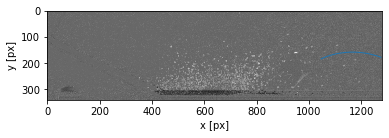

In [53]:
# take a look at the tracks
for i in range(len(particle_id_array)):
    jjj = (t1a['particle'] == particle_id_array[i])
    #print(particle_id_array[i])
    tp.plot_traj(t1a[jjj],superimpose=video[imid]) #the tracks I want

In [54]:
len_track(t1a)  # to help me find the tracks I want
#prints track# , max-min frame number, and mean x in pixels of all tracks
# they all seem good

0 87 416
1 79 768
14 68 1027
46 37 1159


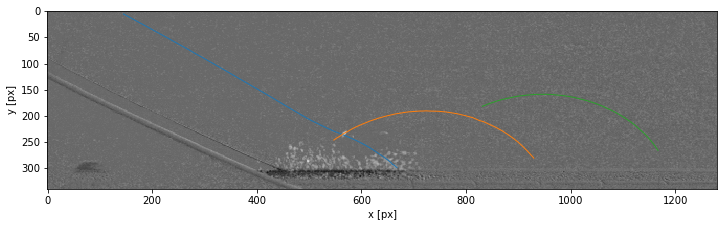

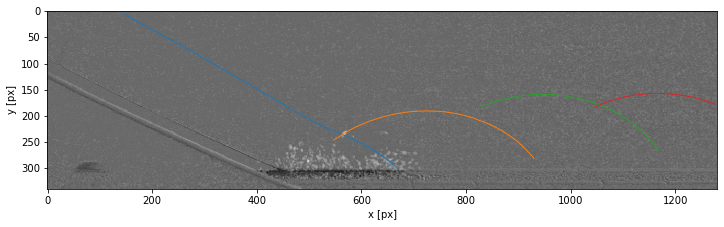

In [55]:
# these are the tracks I want
# it took some adjustment to make sure I got these and not others
iii = ((t1a['particle'] == 0) | (t1a['particle'] == 1)| (t1a['particle'] == 14)|  (t1a['particle'] == 44))                                

imid=110
plt.figure(figsize=(12,4))
ax=tp.plot_traj(t1a[iii],superimpose=video[imid]) #the tracks I want
plt.figure(figsize=(12,4))
ax=tp.plot_traj(t1a,superimpose=video[imid])  #all tracks

t1b_r = t1a[iii]  #save a copy of the tracks I want

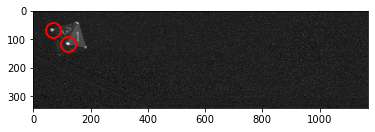

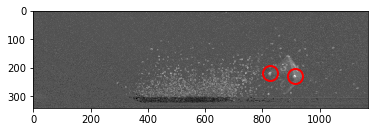

<AxesSubplot:>

In [56]:
# for tracking green dots
# adjust and check spot radius and minmass on single images 
# for finding spots on the marble 
video = processed_video_g

rrad = 9 # radius , adjust this! we will use these values later on
minmass = 800.  # how bright are peaks, adjust this!
xx0=60; xx1=1230 # for display of image
imid = 30
f = tp.locate(video[imid][:,xx0:xx1], rrad, invert=False, \
              minmass=minmass)
tp.annotate(f, video[imid][:,xx0:xx1])

xx0=60; xx1=1230 # for display of image
imid = 200
f = tp.locate(video[imid][:,xx0:xx1], rrad, invert=False, \
              minmass=minmass)
tp.annotate(f, video[imid][:,xx0:xx1])

# parameters look ok
# filter out stuff that is too far

In [57]:
# track the green dot
maxdist = 22  # max distance between frames for linking
memory=13 #how many frames trajectory can go missing in linking
stublength = 20  # remove short tracks
f0=5 # first frame
t1a,particle_id_array=track_link_stub(video,rrad,minmass,f0,maxdist,memory,stublength)

Frame 318: 1 trajectories present.
Before: 15
After: 5
[ 0  1  2  7 12]


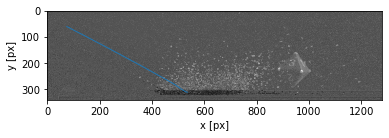

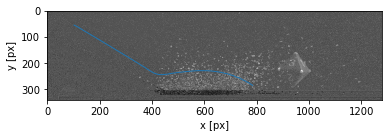

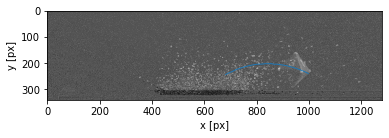

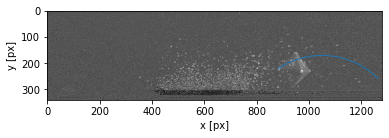

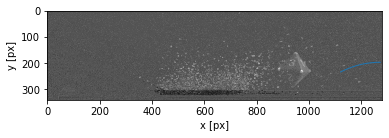

In [58]:
# take a look at the tracks
for i in range(len(particle_id_array)):
    jjj = (t1a['particle'] == particle_id_array[i])
    #print(particle_id_array[i])
    tp.plot_traj(t1a[jjj],superimpose=video[imid]) #the tracks I want
# they all look good

In [59]:
t1b_g = t1a  #save a copy of the tracks I want, which is all of them

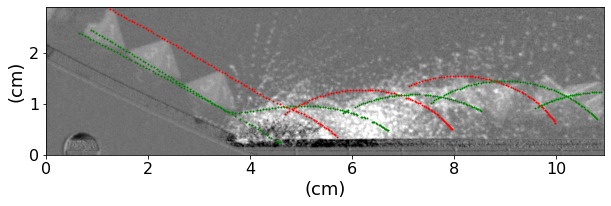

In [60]:
# make a nicer figure of seq with trajectories from t1b trajectory table
vminfac=2  # for display, should be >=1
vmaxfac=1.5
fig,ax = plt.subplots(1,1,figsize=(10,4))
dy=seq_b.shape[0]*pixscale/10  #put axes in cm
dx=seq_b.shape[1]*pixscale/10
extent =([0,dx,0,dy])
vmi = np.min(seq_b); vma = np.max(seq_b)
ax.imshow(seq_b, cmap='gray' ,vmin=vmi/vminfac,vmax=vma/vmaxfac,extent=extent)
ax.set_xlabel('(cm)',fontsize=18)
ax.set_ylabel('(cm)',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
# plot the red tracks
plt.plot(t1b_r.x*pixscale/10,dy-t1b_r.y*pixscale/10,'.',color='red',\
         markersize=2)
plt.plot(t1b_g.x*pixscale/10,dy-t1b_g.y*pixscale/10,'.',color='green',\
         markersize=2)
ofile = oroot + '_seq_b.png'
plt.savefig(ofile)  # 0.1 sec between images

In [61]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [62]:
print(t1b_r.x)

frame
19      144.964706
20      151.963496
21      157.890824
22      164.909740
23      170.810566
24      177.769153
25      183.782424
26      190.695326
27      195.963575
28      201.912848
29      208.900171
30      214.834222
31      221.788000
32      227.766497
33      233.974635
34      239.937545
35      245.846838
36      252.751485
37      257.973793
38      264.930757
39      270.872773
40      277.023446
41      284.698646
42      289.930382
43      296.867150
44      302.800682
45      309.000143
46      314.900414
47      321.792338
48      328.705767
49      333.945701
50      339.838937
51      345.978666
52      352.911223
53      358.800730
54      365.013806
55      370.844201
56      377.029744
57      383.993818
58      389.919972
59      396.738373
60      401.893895
61      408.749071
62      414.975133
63      420.847791
64      426.994302
65      432.863705
66      439.010926
67      445.889516
68      452.734827
69      457.938100
70      464.781393
71    

In [63]:
print(t1b_r.y)

frame
19       5.308676
20       8.963205
21      12.197278
22      16.009096
23      19.178196
24      23.002016
25      26.180164
26      30.062463
27      32.915382
28      36.138319
29      40.001143
30      43.182355
31      47.072741
32      50.268172
33      53.857021
34      57.080029
35      60.315076
36      64.208955
37      67.123729
38      70.963695
39      74.268738
40      77.948729
41      82.113117
42      85.067797
43      88.931872
44      92.258892
45      95.886211
46      99.158688
47     103.069076
48     107.056159
49     110.033937
50     113.347270
51     116.948514
52     120.918891
53     124.296058
54     127.888997
55     131.238171
56     134.943515
57     138.872840
58     142.258650
59     146.201978
60     149.327326
61     153.300253
62     156.963884
63     160.398453
64     164.051140
65     167.480271
66     171.198287
67     175.210991
68     179.210405
69     182.259892
70     186.293161
71     189.967173
72     193.445287
73     197.185645
74  

In [64]:
print(t1b_g.x)

frame
14       73.936214
15       81.580230
16       87.695372
17       94.730234
18      100.821741
19      107.053304
20      114.666149
21      120.921116
22      127.863207
23      133.980151
24      141.733740
25      148.741745
26      154.861616
26      102.022499
27      107.764216
27      162.612947
28      114.614785
28      168.728960
29      120.682696
29      175.711067
30      126.663096
30      181.782732
31      132.723793
31      188.840202
32      194.971854
32      138.948606
33      145.030615
33      202.715008
34      151.758894
34      208.872358
35      157.912829
35      215.820377
36      164.761424
36      222.798706
37      170.052103
37      228.901017
38      236.629708
38      176.876612
39      183.694712
39      243.607752
40      189.879465
40      249.802257
41      196.674268
41      255.814115
42      201.997412
42      262.781325
43      270.575367
43      208.778541
44      276.665995
44      214.888479
45      221.769442
45      283.647162
46    

In [65]:
print(t1b_g.y)

frame
14      59.548697
15      63.337440
16      66.536016
17      70.322647
18      73.421432
19      76.986244
20      80.438066
21      84.032340
22      87.386826
23      90.534026
24      94.456617
25      98.141297
26     101.395833
26      54.011099
27      56.957710
27     105.311174
28      60.254703
28     108.425541
29      64.053212
29     112.239657
30      67.392405
30     115.436162
31      71.252532
31     119.134995
32     122.497429
32      75.151926
33      78.482883
33     126.283928
34      82.387779
34     129.590786
35      86.193021
35     133.307111
36      90.165178
36     137.126585
37      93.443826
37     140.317930
38     144.280560
38      97.403127
39     101.265056
39     148.121870
40     105.136148
40     151.306521
41     109.130635
41     154.515020
42     112.377896
42     158.413572
43     162.294126
43     116.403382
44     165.565901
44     120.177991
45     124.210835
45     169.317838
46     127.450349
46     172.472366
47     131.424360
47  